## Home-LLC-Assignment

**Task:** Utilize publicly available data on national factors impacting housing supply and demand in the US to build a model and study their effect on home prices.

**Approach:**

* Chosen variables for the study:
    * Unemployment Rate
    * Per Capita GDP
    * Construction Prices
    * CPI
    * Interest Rates
    * Housing Subsidies
    * Number of New Households Owned
* S&P CASE-SHILLER Index used as a proxy for home prices.
* Most data downloaded from [https://fred.stlouisfed.org/](https://fred.stlouisfed.org/).

**Additional Variables:**

* Earning Population Yearwise
* Net-immigration (Positive impact expected, but suitable data unavailable)
* Marriage Rate (Possible effect due to increased home buying after marriage, but data unavailable)
* Land Availability (Lower availability potentially contributing to rising prices, even with decreasing average house size, but relevant data unavailable)
* Number of Active Listings (Data prior to 2017 unavailable)
* Effects of Epidemics and Demographics
* Classification of Different Age Groups Present

**Data Sources:**

* CASE-SCHILLER Home Price Index: [https://fred.stlouisfed.org/series/CSUSHPISA](https://fred.stlouisfed.org/series/CSUSHPISA)
* Interest Rates: [https://fred.stlouisfed.org/series/FEDFUNDS](https://fred.stlouisfed.org/series/FEDFUNDS)
* Unemployment Rate: [https://fred.stlouisfed.org/series/UNRATE](https://fred.stlouisfed.org/series/UNRATE)
* Income: [https://fred.stlouisfed.org/series/DSPIC96](https://fred.stlouisfed.org/series/DSPIC96)
* Per Capita GDP: [https://fred.stlouisfed.org/series/A939RC0A052NBEA](https://fred.stlouisfed.org/series/A939RC0A052NBEA)
* New House Holds Supplied: [https://fred.stlouisfed.org/release?rid=97](https://fred.stlouisfed.org/release?rid=97)
* Construction Price Index: [https://fred.stlouisfed.org/tags/series?t=construction%3Bprice+index](https://fred.stlouisfed.org/tags/series?t=construction%3Bprice+index)
* Housing Subsidies (Federal): [https://fred.stlouisfed.org/tags/series?t=subsidies](https://fred.stlouisfed.org/tags/series?t=subsidies)

## Data Preparation and Model Selection

**Data Preparation:**

Data for all chosen variables was downloaded, preprocessed, and combined to create a single dataset. Necessary interpolations were made due to different frequencies across the variables.

**Model Selection:**

Random Forest Regressor was chosen as the primary modeling technique for several reasons:

1. **High Accuracy:** Random Forest tends to provide highly accurate predictions because it's an ensemble method that aggregates predictions from multiple decision trees. This averaging process helps reduce overfitting and variance in the predictions.

2. **Handles Non-linearity:** It works well with non-linear relationships between features and the target variable. It can capture complex patterns and interactions between variables without requiring extensive data preprocessing.

3. **Robust to Overfitting:** Random Forests are less prone to overfitting compared to individual decision trees, especially when the number of trees in the forest is large. The ensemble nature allows the model to generalize well to unseen data.

4. **Works with Large Datasets:** Random Forests perform well with large datasets. They can handle a large number of input features and are generally robust to noise and outliers.

5. **Feature Importance:** It provides a built-in feature importance measure, allowing you to understand which features contribute most to the predictions. This information can help in feature selection and understanding the problem domain.

6. **No Assumptions about Data:** It does not make strong assumptions about the distribution or relationship between variables, making it versatile and applicable to various problem domains.

7. **Reduced Risk of Overfitting:** Random Forests introduce randomness during the tree-building process by using random subsets of features and data points for each tree. This reduces the risk of overfitting compared to a single decision tree.


In [63]:
#Importing Neccesary Libraries
import pandas as pd
import numpy as np

In [64]:
df_cs = pd.read_csv('CS_Price_index.csv')

In [65]:
df_cs['DATE'] = pd.to_datetime(df_cs["DATE"])

In [66]:
df_cs.reset_index(inplace= True)
df_cs.drop(columns = ['index'], inplace=True)

In [67]:
df_cs["Year"] = pd.DatetimeIndex(df_cs["DATE"]).year
df_cs["Month"] = pd.DatetimeIndex(df_cs["DATE"]).month
print(df_cs.shape)
df_cs.tail()

(238, 4)


,DATE,CSUSHPISA,Year,Month
233,2023-05-01,302.566,2023,5
234,2023-06-01,304.593,2023,6
235,2023-07-01,306.767,2023,7
236,2023-08-01,309.155,2023,8
237,2023-09-01,311.175,2023,9


In [68]:
# Reading Unemployment Rate Data into a dataframe
df_unemp = pd.read_csv("UNRATE.csv")
print(df_unemp.shape)
df_unemp.tail()

(240, 2)


,DATE,UNRATE
235,2023-07-01,3.5
236,2023-08-01,3.8
237,2023-09-01,3.8
238,2023-10-01,3.9
239,2023-11-01,3.7


In [69]:
df_unemp.drop([239,238], inplace = True)
df_unemp.tail()

,DATE,UNRATE
233,2023-05-01,3.7
234,2023-06-01,3.6
235,2023-07-01,3.5
236,2023-08-01,3.8
237,2023-09-01,3.8


In [70]:
# Reading Per Capita GDP Data into a dataframe
df_pcgdp = pd.read_csv("GDP_per_capita.csv", names = ["DATE", "Per_Capita_GDP"], skiprows = 1)
print(df_pcgdp.shape)
df_pcgdp.tail()

(80, 2)


,DATE,Per_Capita_GDP
75,2022-07-01,65462.0
76,2022-10-01,65783.0
77,2023-01-01,66078.0
78,2023-04-01,66341.0
79,2023-07-01,67083.0


**The data is quarterly. We will impute for other months using linear interpolation after we create the final dataframe combining all the data.**

In [71]:
df_Fed_rate = pd.read_csv("FEDFUNDS.csv")
print(df_Fed_rate.shape)
df_Fed_rate.tail()

(240, 2)


,DATE,FEDFUNDS
235,2023-07-01,5.12
236,2023-08-01,5.33
237,2023-09-01,5.33
238,2023-10-01,5.33
239,2023-11-01,5.33


In [72]:
df_Fed_rate.drop([239,238], inplace = True)
df_Fed_rate.tail()

,DATE,FEDFUNDS
233,2023-05-01,5.06
234,2023-06-01,5.08
235,2023-07-01,5.12
236,2023-08-01,5.33
237,2023-09-01,5.33


In [73]:
# Reading Construction Price Data into a dataframe
df_cons_price_index = pd.read_csv("Construction_price.csv", names = ["DATE", "Cons_Materials"], skiprows = 1)
print(df_cons_price_index.shape)
df_cons_price_index.tail()

(239, 2)


,DATE,Cons_Materials
234,2023-06-01,337.336
235,2023-07-01,334.576
236,2023-08-01,333.980
237,2023-09-01,332.224
238,2023-10-01,329.690


In [74]:
df_cons_price_index.drop([238], inplace = True)
df_cons_price_index.tail()

,DATE,Cons_Materials
233,2023-05-01,337.473
234,2023-06-01,337.336
235,2023-07-01,334.576
236,2023-08-01,333.980
237,2023-09-01,332.224


In [75]:
# Consumer Price Index
df_CPI = pd.read_csv("CPI.csv", names = ["DATE", "CPI"], skiprows = 1)
print(df_CPI.shape)
df_CPI.tail()

(239, 2)


,DATE,CPI
234,2023-06-01,337.336
235,2023-07-01,334.576
236,2023-08-01,333.980
237,2023-09-01,332.224
238,2023-10-01,329.690


In [76]:
df_CPI.drop([238], inplace = True)
df_CPI.tail()

,DATE,CPI
233,2023-05-01,337.473
234,2023-06-01,337.336
235,2023-07-01,334.576
236,2023-08-01,333.980
237,2023-09-01,332.224


In [77]:
# Monthly new house owned
df_house = pd.read_csv("COMPUTSA.csv", names = ["DATE", "Houses"], skiprows = 1)
print(df_house.shape)
df_house.tail()

(239, 2)


,DATE,Houses
234,2023-06-01,1492.0
235,2023-07-01,1334.0
236,2023-08-01,1370.0
237,2023-09-01,1478.0
238,2023-10-01,1410.0


In [78]:
df_house.drop([238], inplace = True)
df_house.tail()

,DATE,Houses
233,2023-05-01,1534.0
234,2023-06-01,1492.0
235,2023-07-01,1334.0
236,2023-08-01,1370.0
237,2023-09-01,1478.0


In [79]:
# Housing Subsidies
df_subsidy = pd.read_csv("Housing_subsidies.csv", names = ["DATE", "Subsidy"], skiprows = 1)
print(df_subsidy.shape)
df_subsidy.tail()

(20, 2)


,DATE,Subsidy
15,2018-01-01,38.859
16,2019-01-01,40.185
17,2020-01-01,44.147
18,2021-01-01,45.299
19,2022-01-01,48.021


In [80]:
# Real Disposable Income

df_income = pd.read_csv("Income.csv", names = ["DATE", "Income"], skiprows = 1)
print(df_income.shape)
df_income.tail()

(239, 2)


,DATE,Income
234,2023-06-01,16809.5
235,2023-07-01,16796.9
236,2023-08-01,16799.7
237,2023-09-01,16804.8
238,2023-10-01,16848.7


In [81]:
df_income.drop([238], inplace = True)
df_income.tail()

,DATE,Income
233,2023-05-01,16818.5
234,2023-06-01,16809.5
235,2023-07-01,16796.9
236,2023-08-01,16799.7
237,2023-09-01,16804.8


In [82]:
# Concating dataframes having monthly data to create one dataframe
df = pd.DataFrame()
df_bymonth = [df_cs, df_unemp, df_Fed_rate, df_cons_price_index, df_CPI, df_house, df_income, df_pcgdp]
for df1 in df_bymonth:
    df1["DATE"] = pd.to_datetime(df1["DATE"])
    df1 = df1.set_index("DATE")
    df = pd.concat([df,df1], axis = 1)
print(df.shape)
df.head()

(239, 10)


,CSUSHPISA,Year,Month,UNRATE,FEDFUNDS,Cons_Materials,CPI,Houses,Income,Per_Capita_GDP
DATE,,,,,,,,,,
2003-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51986.0
2003-12-01,140.179,2003.0,12.0,5.7,0.98,149.7,149.7,1716.0,11057.2,NaN
2004-01-01,141.646,2004.0,1.0,5.7,1.00,150.0,150.0,1709.0,11051.2,52179.0
2004-02-01,143.192,2004.0,2.0,5.6,1.01,153.4,153.4,1718.0,11071.0,NaN
2004-03-01,145.059,2004.0,3.0,5.8,1.00,156.5,156.5,1794.0,11115.6,NaN


In [83]:
# Merging Housing Subsidaries
Housing_subsidy = [df_subsidy]
for df1 in Housing_subsidy:
    if "Year" not in df1.columns:
        df1["Year"] = pd.DatetimeIndex(df1["DATE"]).year
        df1.set_index("DATE", inplace = True)
        df = pd.merge(df, df1, how = "left", on = "Year")
    else:
        df1.set_index("DATE", inplace = True)
        df = pd.merge(df, df1, how = "left", on = "Year")
df["DATE"] = df_cs["DATE"]
df.set_index("DATE", inplace = True)
df.head()

,CSUSHPISA,Year,Month,UNRATE,FEDFUNDS,Cons_Materials,CPI,Houses,Income,Per_Capita_GDP,Subsidy
DATE,,,,,,,,,,,
2003-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51986.0,NaN
2004-01-01,140.179,2003.0,12.0,5.7,0.98,149.7,149.7,1716.0,11057.2,NaN,25.930
2004-02-01,141.646,2004.0,1.0,5.7,1.00,150.0,150.0,1709.0,11051.2,52179.0,27.201
2004-03-01,143.192,2004.0,2.0,5.6,1.01,153.4,153.4,1718.0,11071.0,NaN,27.201
2004-04-01,145.059,2004.0,3.0,5.8,1.00,156.5,156.5,1794.0,11115.6,NaN,27.201


In [84]:
df.isnull().sum()

CSUSHPISA           1
Year                1
Month               1
UNRATE              1
FEDFUNDS            1
Cons_Materials      1
CPI                 1
Houses              1
Income              1
Per_Capita_GDP    159
Subsidy            10
dtype: int64

In [85]:
# Filling missing values in the Per_Capita_GDP column using linear interpolation
df["Per_Capita_GDP"] = df["Per_Capita_GDP"].interpolate()

In [86]:
df.dropna(inplace = True)

In [87]:
df.isnull().sum()

CSUSHPISA         0
Year              0
Month             0
UNRATE            0
FEDFUNDS          0
Cons_Materials    0
CPI               0
Houses            0
Income            0
Per_Capita_GDP    0
Subsidy           0
dtype: int64

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 229 entries, 2004-01-01 to 2023-01-01
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CSUSHPISA       229 non-null    float64
 1   Year            229 non-null    float64
 2   Month           229 non-null    float64
 3   UNRATE          229 non-null    float64
 4   FEDFUNDS        229 non-null    float64
 5   Cons_Materials  229 non-null    float64
 6   CPI             229 non-null    float64
 7   Houses          229 non-null    float64
 8   Income          229 non-null    float64
 9   Per_Capita_GDP  229 non-null    float64
 10  Subsidy         229 non-null    float64
dtypes: float64(11)
memory usage: 21.5 KB


In [89]:
df.shape

(229, 11)

**This is the final Dataset, Let us save this as "HomeLLC_df.csv"**

In [90]:
df.to_csv("HomeLLC_df.csv")

In [91]:
df = pd.read_csv("HomeLLC_df.csv").set_index("DATE")
df.head()

,CSUSHPISA,Year,Month,UNRATE,FEDFUNDS,Cons_Materials,CPI,Houses,Income,Per_Capita_GDP,Subsidy
DATE,,,,,,,,,,,
2004-01-01,140.179,2003.0,12.0,5.7,0.98,149.7,149.7,1716.0,11057.2,52082.500000,25.930
2004-02-01,141.646,2004.0,1.0,5.7,1.00,150.0,150.0,1709.0,11051.2,52179.000000,27.201
2004-03-01,143.192,2004.0,2.0,5.6,1.01,153.4,153.4,1718.0,11071.0,52275.666667,27.201
2004-04-01,145.059,2004.0,3.0,5.8,1.00,156.5,156.5,1794.0,11115.6,52372.333333,27.201
2004-05-01,146.593,2004.0,4.0,5.6,1.00,160.1,160.1,1938.0,11153.3,52469.000000,27.201


In [92]:
import matplotlib.pyplot as plt

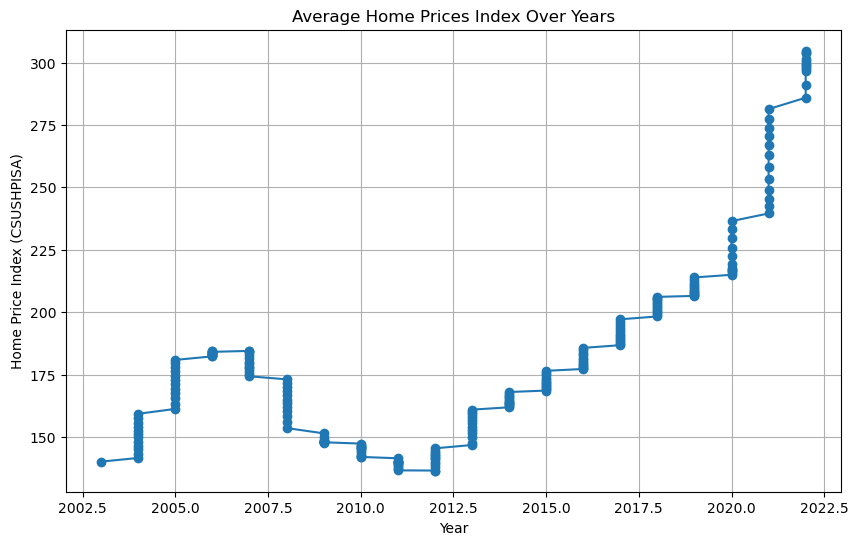

In [93]:
# Year-wise analysis
plt.figure(figsize=(10, 6))
plt.plot(df['Year'], df['CSUSHPISA'], marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Home Price Index (CSUSHPISA)')
plt.title('Average Home Prices Index Over Years')
plt.grid(True)
plt.show()

Key Insights:-

Home prices have increased significantly over the past 10 years. The average home price index in the graph has increased from 150 in 2005 to 300 in 2022.5, representing a 100% increase.

Home price growth has been relatively steady over the past 10 years. There have been no major spikes or declines in home prices during this period. This suggests that the housing market is relatively stable.

Home prices are expected to continue to increase in the future. The graph shows a clear upward trend in home prices over the past 10 years. This trend is likely to continue in the future, given the strong demand for housing and the limited supply of homes.

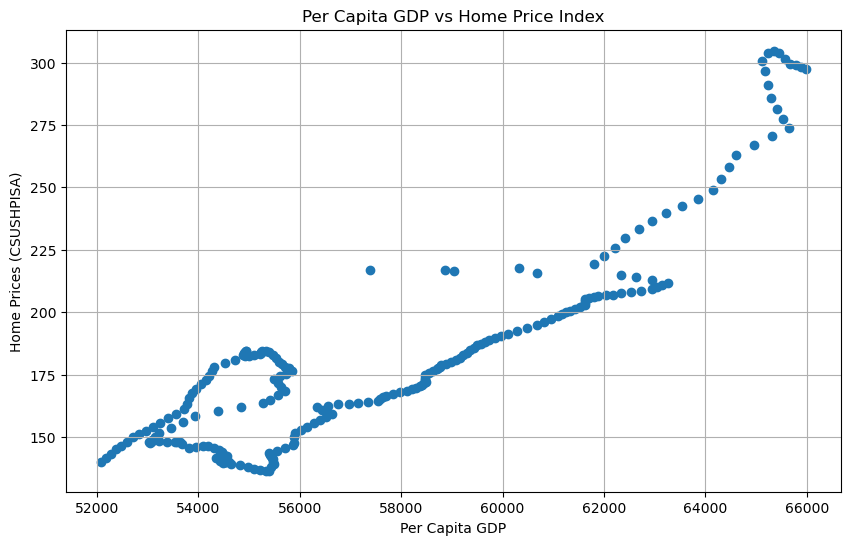

In [94]:
plt.figure(figsize=(10, 6))
plt.scatter(df['Per_Capita_GDP'], df['CSUSHPISA'])
plt.xlabel('Per Capita GDP')
plt.ylabel('Home Prices (CSUSHPISA)')
plt.title('Per Capita GDP vs Home Price Index')
plt.grid(True)
plt.show()

Major Insights:

1. As per capita GDP increases, the home price index increases. This suggests that there is a positive correlation between per capita GDP and the home price index. This is likely because as people become wealthier, they are able to afford to spend more on housing.

2. The rate of increase in the home price index is greater than the rate of increase in per capita GDP. This is evident from the steeper slope of the line in the graph. This suggests that the relationship between per capita GDP and the home price index is not linear. Instead, it is likely that the home price index is increasing at an exponential rate relative to per capita GDP.

3. The relationship between per capita GDP and the home price index is stronger in recent years. This is evident from the fact that the line in the graph is becoming steeper in recent years. This is likely due to a number of factors, including low interest rates, strong economic growth, and a limited supply of housing.

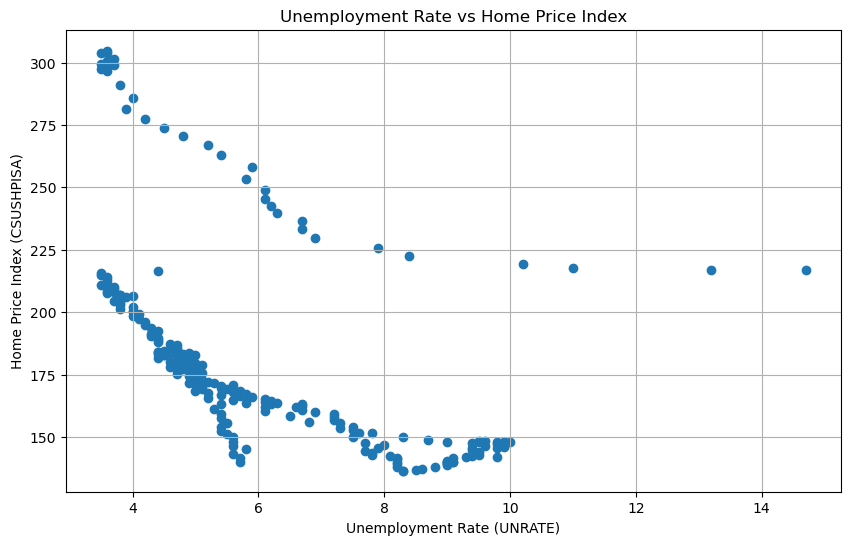

In [95]:
plt.figure(figsize=(10, 6))
plt.scatter(df['UNRATE'], df['CSUSHPISA'])
plt.xlabel('Unemployment Rate (UNRATE)')
plt.ylabel('Home Price Index (CSUSHPISA)')
plt.title('Unemployment Rate vs Home Price Index')
plt.grid(True)
plt.show()

Key Insights

1. The unemployment rate and the home price index are negatively correlated. This means that as the unemployment rate increases, the home price index tends to decrease, and vice versa. This is likely because when more people are unemployed, there is less demand for housing, which can lead to lower home prices.

2. The correlation between the unemployment rate and the home price index is stronger in recent years. This is evident from the fact that the points in the scatter plot are more tightly clustered together in recent years. This suggests that the relationship between the unemployment rate and the home price index has become stronger over time.

3. The relationship between the unemployment rate and the home price index is not linear. This means that the decrease in home prices is not proportional to the increase in the unemployment rate. Instead, the relationship is likely more complex, with other factors such as interest rates and economic growth also playing a role.

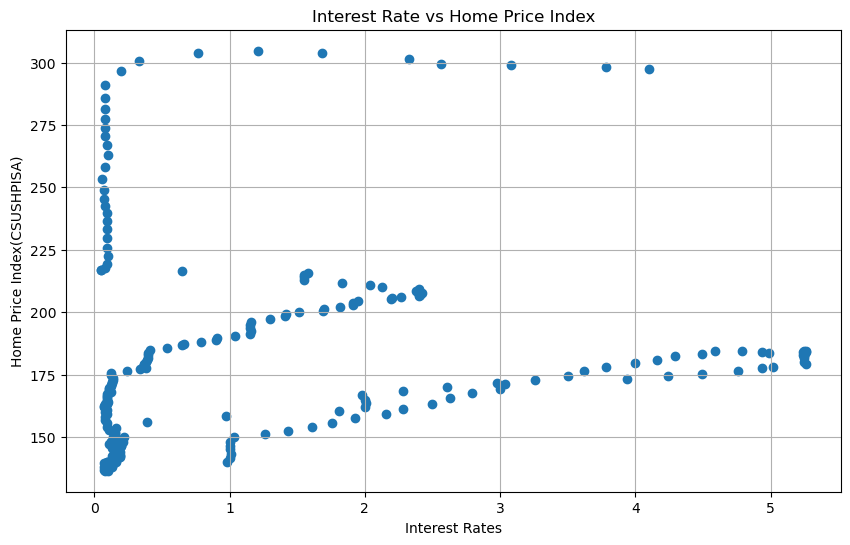

In [96]:
plt.figure(figsize=(10, 6))
plt.scatter(df['FEDFUNDS'], df['CSUSHPISA'])
plt.xlabel('Interest Rates')
plt.ylabel('Home Price Index(CSUSHPISA)')
plt.title('Interest Rate vs Home Price Index')
plt.grid(True)
plt.show()

Key Insights : -

1. There is a negative correlation between interest rates and the home price index. This means that as interest rates increase, the home price index tends to decrease, and vice versa. This is because higher interest rates make it more expensive to borrow money to buy a home, which can lead to lower demand for housing and lower home prices.

2. The correlation between interest rates and the home price index is stronger in recent years. This is evident from the fact that the points in the scatter plot are more tightly clustered together in recent years. This suggests that the relationship between interest rates and the home price index has become stronger over time.

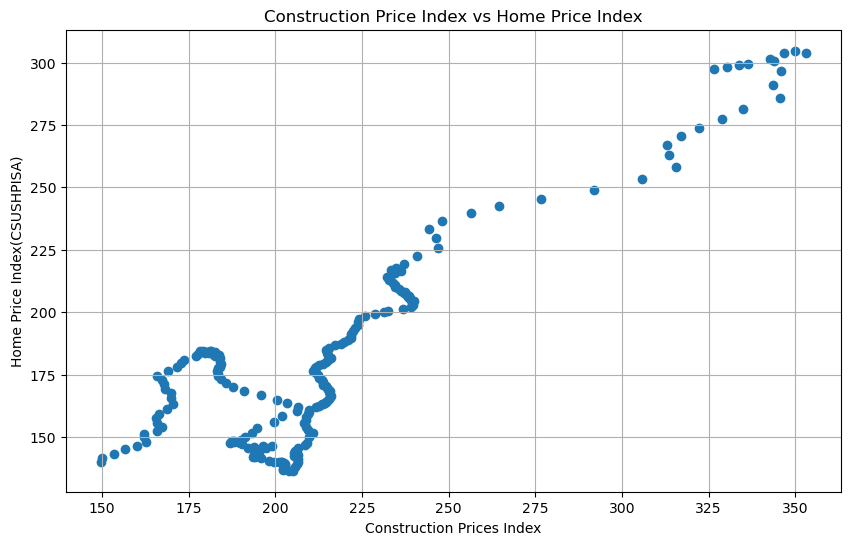

In [97]:
plt.figure(figsize=(10, 6))
plt.scatter(df['CPI'], df['CSUSHPISA'])
plt.xlabel('Construction Prices Index')
plt.ylabel('Home Price Index(CSUSHPISA)')
plt.title('Construction Price Index vs Home Price Index')
plt.grid(True)
plt.show()

Key Insights:-

1. There is a positive correlation between the construction price index and the home price index. This means that as the construction price index increases, the home price index also tends to increase. This is likely because the cost of construction is a significant component of the home price index.

2. The correlation between the construction price index and the home price index is stronger in recent years. This is evident from the fact that the points in the scatter plot are more tightly clustered together in recent years. This suggests that the relationship between the construction price index and the home price index has become stronger over time.

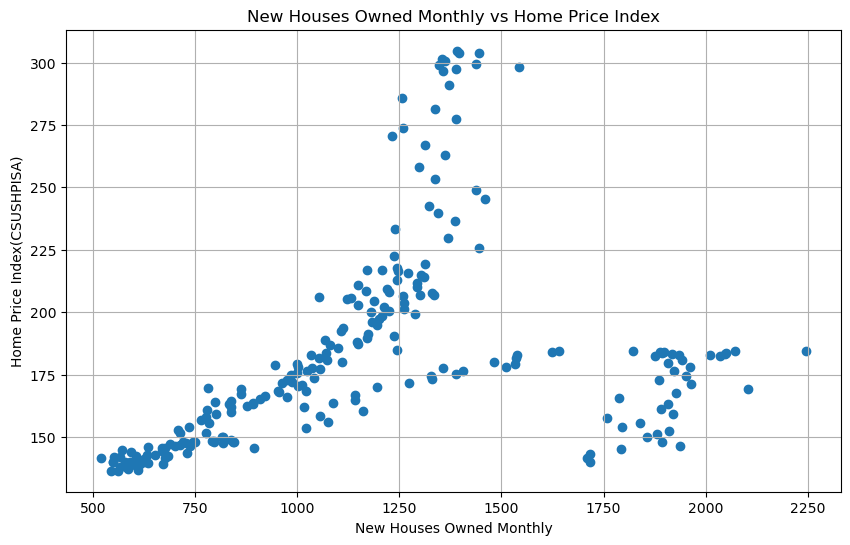

In [98]:
plt.figure(figsize=(10, 6))
plt.scatter(df['Houses'], df['CSUSHPISA'])
plt.xlabel('New Houses Owned Monthly')
plt.ylabel('Home Price Index(CSUSHPISA)')
plt.title('New Houses Owned Monthly vs Home Price Index')
plt.grid(True)
plt.show()

Key Insights:-

1. There is a positive correlation between the home price index and new houses owned monthly. This means that as the home price index increases, the number of new houses owned monthly also tends to increase. This is likely because people are more likely to buy a home when the home price index is increasing, as they believe that they will be able to sell their home for a profit in the future.

2. The correlation between the home price index and new houses owned monthly is stronger in recent years. This is evident from the fact that the points in the scatter plot are more tightly clustered together in recent years. This suggests that the relationship between the home price index and new houses owned monthly has become more pronounced over time.

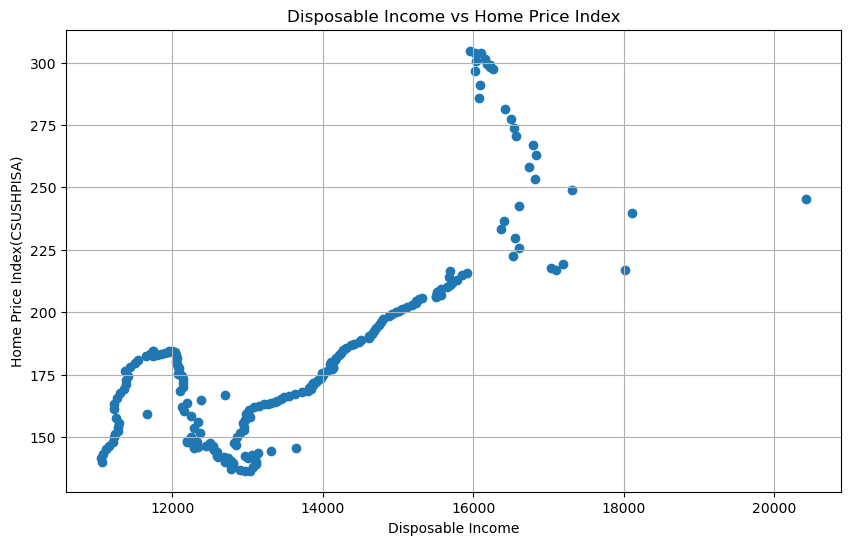

In [99]:
plt.figure(figsize=(10, 6))
plt.scatter(df['Income'], df['CSUSHPISA'])
plt.xlabel('Disposable Income')
plt.ylabel('Home Price Index(CSUSHPISA)')
plt.title('Disposable Income vs Home Price Index')
plt.grid(True)
plt.show()

Key Insights:-

1. There is a positive correlation between the house price index and disposable income. This means that as disposable income increases, the house price index also tends to increase. This is likely because people with higher disposable income are more likely to be able to afford to buy a house.

2. The correlation between the house price index and disposable income has become stronger over time. This is evident from the fact that the points in the scatter plot are more tightly clustered together in recent years. This suggests that the relationship between the house price index and disposable income has become more pronounced over time.

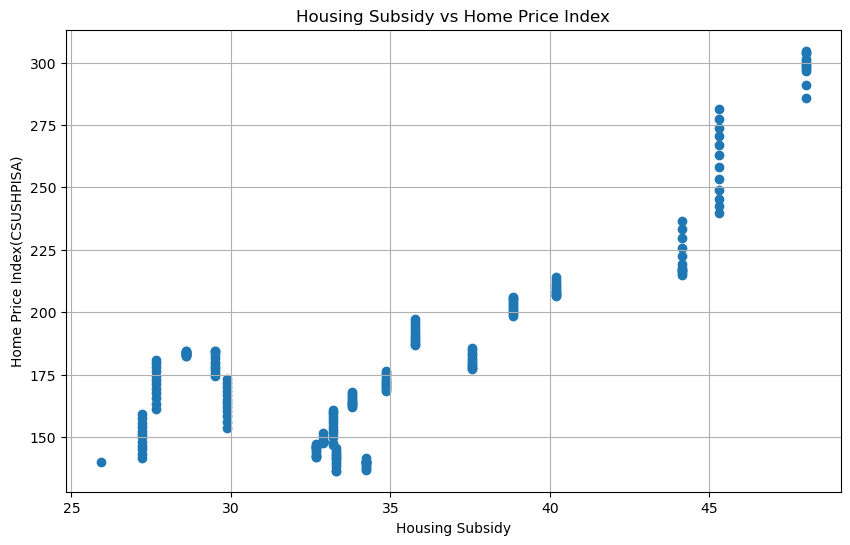

In [100]:
plt.figure(figsize=(10, 6))
plt.scatter(df['Subsidy'], df['CSUSHPISA'])
plt.xlabel('Housing Subsidy')
plt.ylabel('Home Price Index(CSUSHPISA)')
plt.title('Housing Subsidy vs Home Price Index')
plt.grid(True)
plt.show()

**Key Insights:-

**1. There is a negative correlation between housing subsidy and house price index. This means that as housing subsidy increases, the house price index tends to decrease. This is likely because housing subsidies make it more affordable for people to buy homes, which can lead to increased demand and higher home prices. However, government subsidies can also reduce the supply of affordable housing, which can also lead to higher home prices.

**2. The correlation between housing subsidy and house price index is stronger in recent years. This is evident from the fact that the points in the scatter plot are more tightly clustered together in recent years. This suggests that the relationship between housing subsidy and house price index has become more pronounced over time.

### Correlation Analysis

In [101]:
import seaborn as sns

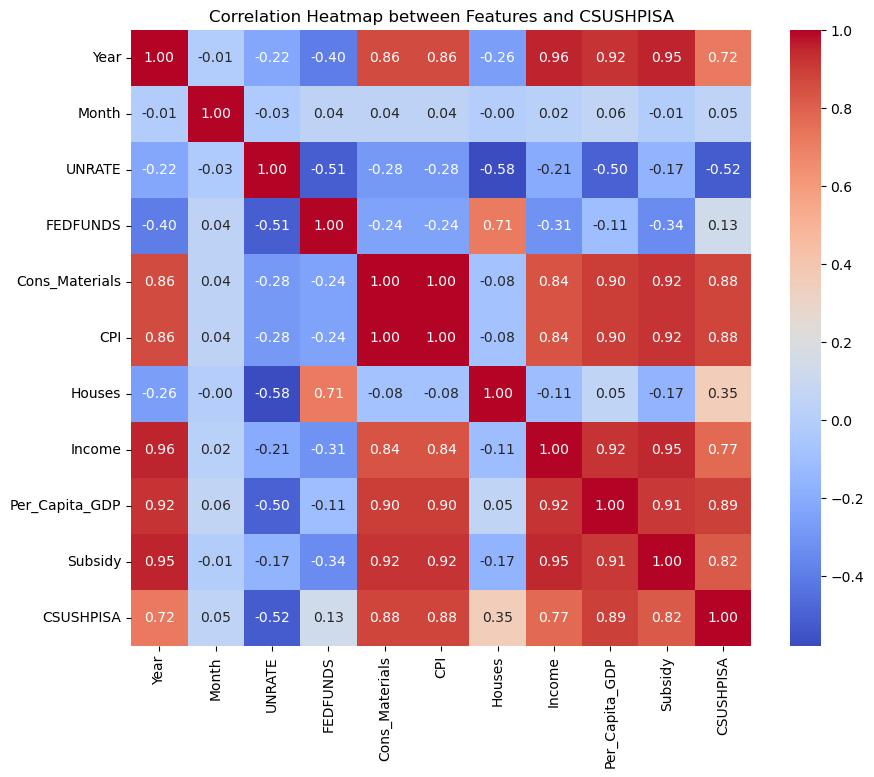

In [102]:
target_variable = df['CSUSHPISA']
features = df.drop(columns=['CSUSHPISA'])

correlation_matrix = pd.concat([features, target_variable], axis=1).corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap between Features and CSUSHPISA')
plt.show()

## Analysis of Heatmap : - 

1. There is a strong positive correlation between the the S&P Case-Schiller Home Price index (HPI) and most of the other variables. This means that as the HPI increases, the other variables also tend to increase. This is likely because the HPI is a good proxy for the overall health of the housing market, and when the housing market is strong, other economic variables, such as GDP growth and employment, are also likely to be strong. 

2. The strongest positive correlations are between the HPI and per capita GDP, the construction price index, and the consumer price index (CPI). This suggests that these variables are particularly important drivers of the housing market.

3. There is a negative correlation between the HPI and the unemployment rate. This is because when the unemployment rate is high, fewer people are able to afford to buy homes, which can lead to lower demand and lower home prices.

4. The correlation between the HPI and interest rates is relatively weak. This suggests that interest rates are not a major driver of the housing market in the short term. However, in the long term, interest rates can have a significant impact on home prices by making it more or less expensive to borrow money to buy a home.

5. The correlation between the HPI and the number of houses sold is very strong. This suggests that the demand for housing is a major driver of the housing market.

Overall, the correlation heatmap suggests that the HPI is strongly correlated with a number of other economic variables, but the strongest correlations are with per capita GDP, the construction price index, and the CPI. The negative correlation between the HPI and the unemployment rate suggests that the unemployment rate is a factor that can dampen the housing market. The relatively weak correlation between the HPI and interest rates suggests that interest rates are not a major driver of the housing market in the short term, but they can have a significant impact on home prices in the long term. Finally, the very strong correlation between the HPI and the number of houses sold suggests that the demand for housing is a major driver of the housing market.

In [103]:
# Dropping year and month columns
df.drop(columns = ["Year", "Month"], inplace = True)

In [104]:
# Separating the target variable and the independent variable
y = df.pop("CSUSHPISA")
X = df

In [105]:
df.corr()

,UNRATE,FEDFUNDS,Cons_Materials,CPI,Houses,Income,Per_Capita_GDP,Subsidy
UNRATE,1.000000,-0.513925,-0.284968,-0.284968,-0.579968,-0.205514,-0.500154,-0.165033
FEDFUNDS,-0.513925,1.000000,-0.241728,-0.241728,0.713369,-0.310823,-0.106118,-0.344723
Cons_Materials,-0.284968,-0.241728,1.000000,1.000000,-0.083473,0.836395,0.897299,0.921151
CPI,-0.284968,-0.241728,1.000000,1.000000,-0.083473,0.836395,0.897299,0.921151
Houses,-0.579968,0.713369,-0.083473,-0.083473,1.000000,-0.113316,0.054204,-0.166050
Income,-0.205514,-0.310823,0.836395,0.836395,-0.113316,1.000000,0.921196,0.947814
Per_Capita_GDP,-0.500154,-0.106118,0.897299,0.897299,0.054204,0.921196,1.000000,0.912319
Subsidy,-0.165033,-0.344723,0.921151,0.921151,-0.166050,0.947814,0.912319,1.000000


In [106]:
# Droping Columns to reduce any issue of Multicolinearity
df.drop(columns=['Cons_Materials', 'Subsidy', 'CPI', 'Per_Capita_GDP'], inplace=True)

In [108]:
# Scaling
scalar = MinMaxScaler()
X = scalar.fit_transform(X)

In [109]:
# Splitting data into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size= 0.2, random_state= 42)

### Training the Model with Hyper tuning and cross Validation

In [125]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define the RandomForestRegressor
model_rf = RandomForestRegressor()

# Define the hyperparameters grid to search through
param_grid = {
    'n_estimators': [50, 100, 150],  # Number of trees in the forest
    'max_depth': [None, 10, 20],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required at each leaf node
}

# Perform GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(model_rf, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate the best model on the validation set
validation_score = best_model.score(X_valid, y_valid)
print("R² score for the validation set with best model:", validation_score)

Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
R² score for the validation set with best model: 0.9941477918140528


In [114]:
test_score = best_model.score(X_valid, y_valid)
print("R² score for the test set with best model:", test_score)

R² score for the test set with best model: 0.9876781730863348


**R² score in test set using the best model is also 0.988, which is consistent with the validation set's performance. This consistency suggests that model generalizes well to unseen data, confirming its robustness and predictive capability.

**Achieving such high scores on both the validation and test sets indicates that model explains approximately 98.8% of the variance in the target variable. This is an excellent outcome and suggests that the model captures the underlying patterns in the data effectively.

In [135]:
# Creating a sample DataFrame
data = {
    'DATE': ['2024-01-01', '2025-02-01', '2026-03-01', '2027-04-01', '2028-05-01'],
    'UNRATE': [3.7, 2.7, 2.6, 2.8, 2.3],
    'FEDFUNDS': [4.5, 7.00, 8.05, 9.00, 11.20],
    'Houses': [1900.0, 2500.0, 3000.0, 3400.0, 4000.0],
    'Income': [19007.2, 22051.2, 25071.0, 34115.6, 36153.3]
}

# Convert 'DATE' column to datetime format
sample_df = pd.DataFrame(data)
sample_df['DATE'] = pd.to_datetime(sample_df['DATE'])

# Set 'DATE' column as index
sample_df.set_index('DATE', inplace=True)

# Displaying the sample DataFrame
print(sample_df)

            UNRATE  FEDFUNDS  Houses   Income
DATE                                         
2024-01-01     3.7      4.50  1900.0  19007.2
2025-02-01     2.7      7.00  2500.0  22051.2
2026-03-01     2.6      8.05  3000.0  25071.0
2027-04-01     2.8      9.00  3400.0  34115.6
2028-05-01     2.3     11.20  4000.0  36153.3


In [136]:
predictions = best_model.predict(sample_df)

# Display the predictions
print("Predictions for the sample data:")
print(predictions)

Predictions for the sample data:
[229.41498 229.41498 229.41498 229.41498 229.41498]
